In [1]:
%reset
import sys
sys.path.append("/Users/jason.wang/Desktop/hif2gene/scripts/helper_functions/") # replace path

# custom modules
import cluster_features_combine_p_values as cf
import hypothesis_testing as ht

# standard packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from copy import deepcopy
import scipy.stats as stats
import pickle as pkl

%reload_ext autoreload
%autoreload 2

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## HIF Clusters (Defined Pan-Cancer)

In [2]:
# Load in HIF groupings based on agglomerative clustering with correlation distance
# Computed on pan-cancer patient-level dataset after removing rows with high NA (missingness)
working_dir = "~/Desktop/hif2gene"
hif_clusters = pd.read_csv("{0}/data/hif_clusters/pancancer.hif.clusters.csv".format(working_dir))
hif_clusters.shape
hif_clusters = hif_clusters.rename(columns={"Unnamed: 0": "HIF", "x": "Cluster Group"})
hif_clusters

,HIF,Cluster Group
0,AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE,1
1,AREA (MM2) OF [ESI_0080] IN [TISSUE]_HE,1
2,AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE,2
3,AREA (MM2) OF [STROMA] IN [TISSUE]_HE,3
4,AREA (MM2) OF [TUMOR] IN [TISSUE]_HE,1
...,...,...
602,TOTAL [MACROPHAGE CELLS] IN [TUMOR]_HE,1
603,TOTAL [PLASMA CELLS] IN [EPITHELIAL]_HE,1
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,9
605,TOTAL [PLASMA CELLS] IN [STROMA]_HE,9


In [3]:
# Number of unique clusters
len(set(hif_clusters['Cluster Group']))

20

In [15]:
# Generate HIF to cluster map
hif2cluster = {}
for ind in hif_clusters.index: 
     hif2cluster[hif_clusters['HIF'][ind].replace("_HE", "_FFPE")] = hif_clusters['Cluster Group'][ind]
# hif2cluster

# LUSC

In [16]:
# Load in LUSC HIF + immune expression signature data
lusc_df = pd.read_csv("{0}/data/genetic_data/PanImmune/processed/lusc.pan.immune.joined.csv".format(working_dir))
lusc_df.shape # includes HIFs, clinical metadata, immune expression scores

(400, 822)

In [17]:
# Extract HIF columns
lusc_hifs = lusc_df.iloc[:, 4:611]
lusc_hifs.shape
lusc_hifs.columns

Index(['AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_FFPE',
       'AREA (MM2) OF [ESI_0080] IN [TISSUE]_FFPE',
       'AREA (MM2) OF [NECROSIS] IN [TISSUE]_FFPE',
       'AREA (MM2) OF [STROMA] IN [TISSUE]_FFPE',
       'AREA (MM2) OF [TUMOR] IN [TISSUE]_FFPE',
       'CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF CANCER IN EPITHELIAL_FFPE',
       'CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF CANCER IN ESI_0080_FFPE',
       'CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF CANCER IN STROMA_FFPE',
       'CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF CANCER IN TUMOR_FFPE',
       'CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF FIBROBLAST IN EPITHELIAL_FFPE',
       ...
       'DENSITY [LYMPHOCYTE CELLS] IN [STROMA]_FFPE',
       'DENSITY [LYMPHOCYTE CELLS] IN [TUMOR]_FFPE',
       'DENSITY [MACROPHAGE CELLS] IN [EPITHELIAL]_FFPE',
       'DENSITY [MACROPHAGE CELLS] IN [ESI_0080]_FFPE',
       'DENSITY [MACROPHAGE CELLS] IN [STROMA]_FFPE',
       'DENSITY [MACROPHAGE CELLS] IN [TUMOR]_FFP

In [18]:
# Extract immune expression columns of interest
expressions_of_interest = [
    'LIexpression_score', # Leukocyte infiltration
    'TGFB_score_21050467', # TGF-beta
    'CHANG_CORE_SERUM_RESPONSE_UP', # Wound healing signature          
    'IgG_19272155' #IgG expression
]
lusc_expressions = lusc_df[expressions_of_interest]
lusc_expressions.shape
lusc_expressions.columns

Index(['LIexpression_score', 'TGFB_score_21050467',
       'CHANG_CORE_SERUM_RESPONSE_UP', 'IgG_19272155'],
      dtype='object')

In [19]:
# Merge dataset 
lusc_df_cleaned = pd.concat([lusc_hifs.reset_index(drop=True), lusc_expressions], axis=1)
lusc_df_cleaned.shape
lusc_df_cleaned.columns

# Remove rows with high NA (missingness)
lusc_df_cleaned = lusc_df_cleaned.dropna(axis="rows") # as expected, 5 rows removed
lusc_df_cleaned.shape

(400, 611)

In [20]:
# Spearman vs. Pearson Correlation
# Spearman: evaluate MONOTONIC relationship between two continuous variables, based on ranked values rather than raw data
# Pearson: evaluate LINEAR relationship between two continuous variables
lusc_spearman_corr = lusc_df_cleaned.corr(method='spearman')
lusc_pearson_corr = lusc_df_cleaned.corr(method='pearson')

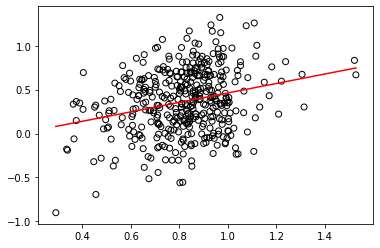

Spearman: 0.2094500045844082
Pearson: 0.25949540634601315


In [21]:
hif_name = 'COUNT PROP [CANCER CELLS] IN [[ESI_0080] OVER [EPITHELIAL]]_FFPE'
y_name = 'TGFB_score_21050467'
hif = lusc_df_cleaned[hif_name]
y = lusc_df_cleaned[y_name]
plt.scatter(hif, y, facecolors='none', edgecolors='black')
plt.plot(np.unique(hif), np.poly1d(np.polyfit(hif, y, 1))(np.unique(hif)), color='r')
plt.show()
print("Spearman: {0}".format(lusc_spearman_corr.iloc[lusc_df_cleaned.columns.get_loc(hif_name), lusc_df_cleaned.columns.get_loc(y_name)]))
print("Pearson: {0}".format(lusc_pearson_corr.iloc[lusc_df_cleaned.columns.get_loc(hif_name), lusc_df_cleaned.columns.get_loc(y_name)]))

### Spearman Correlation Analysis

In [22]:
# Compute Spearman correlation + generate P-value
y_name = 'LIexpression_score'
y = lusc_df_cleaned[y_name]

# Iterate through columns of HIF dataframe
lusc_df_spearman = pd.DataFrame()
hif_cluster_groups = list(hif_clusters['Cluster Group'])

for hif_name in lusc_df_cleaned.iloc[:,0:607]:
    # print(hif_name)
    hif = lusc_df_cleaned[hif_name]
    rho, pval = stats.spearmanr(hif, y)
    lusc_df_spearman = lusc_df_spearman.append(pd.DataFrame({
        "HIF": [hif_name],
        "Rho": [rho],
        "P-Value": [pval],
        "Cluster Group": [hif2cluster[hif_name]]
    }))

# Index dataframe by HIF name
lusc_df_spearman = lusc_df_spearman.set_index('HIF')

In [23]:
lusc_df_spearman.sort_values(by="Rho", ascending=False)

,Rho,P-Value,Cluster Group
HIF,,,
COUNT PROP [[[CANCER CELLS] SELECTED BY [PLASMA_RADIUS_80]] OVER [[CANCER CELLS] SELECTED BY [FIBROBLAST_RADIUS_80]]] IN [ESI_0080]_FFPE,0.499567,1.221854e-26,9
COUNT PROP [[[CANCER CELLS] SELECTED BY [PLASMA_RADIUS_80]] OVER [CANCER CELLS]] IN [ESI_0080]_FFPE,0.490048,1.490550e-25,9
COUNT PROP [[[CANCER CELLS] SELECTED BY [PLASMA_RADIUS_80]] OVER [[CANCER CELLS] SELECTED BY [FIBROBLAST_RADIUS_80]]] IN [STROMA]_FFPE,0.489061,1.922988e-25,9
COUNT PROP [[[CANCER CELLS] SELECTED BY [PLASMA_RADIUS_80]] OVER [[CANCER CELLS] SELECTED BY [FIBROBLAST_RADIUS_80]]] IN [TUMOR]_FFPE,0.477887,3.255129e-24,9
DENSITY [PLASMA CELLS] IN [ESI_0080]_FFPE,0.475114,6.464128e-24,9
...,...,...,...
COUNT PROP [[CANCER CELLS] OVER [[CANCER CELLS] SELECTED BY [PLASMA_RADIUS_80]]] IN [STROMA]_FFPE,-0.463755,1.006993e-22,9
COUNT PROP [[[CANCER CELLS] SELECTED BY [FIBROBLAST_RADIUS_80]] OVER [[CANCER CELLS] SELECTED BY [PLASMA_RADIUS_80]]] IN [TUMOR]_FFPE,-0.477887,3.255129e-24,9
COUNT PROP [[[CANCER CELLS] SELECTED BY [FIBROBLAST_RADIUS_80]] OVER [[CANCER CELLS] SELECTED BY [PLASMA_RADIUS_80]]] IN [STROMA]_FFPE,-0.489061,1.922988e-25,9


In [24]:
# HIFs are highly-correlated; thus P-values are correlated / dependent
# Apply the Empirical Brown's Method to combine P-values

# Normalize (convert to z-score) matrix (required as input)
lusc_df_mu = lusc_df_cleaned.iloc[:,0:607].mean().values # mean per HIF column
lusc_df_sigma = lusc_df_cleaned.iloc[:,0:607].std().values # standard deviation per HIF column
lusc_df_normalized = (lusc_df_cleaned.iloc[:,0:607] - lusc_df_mu)/lusc_df_sigma


# Generate combined P-values within HIF clusters
combined_pvals = cf.combine_p_values(np.array(hif_cluster_groups), lusc_df_spearman, 
                                     lusc_df_normalized, p_val_col='P-Value')

In [25]:
# False discovery rate / multiple hypothesis correction via Benjamini-Hochberg
significant, ebm_q_values = ht.bh_correction(combined_pvals, alpha=0.05) # Q-values = corrected P-values

In [26]:
# Compute summary statistics (e.g. median / mean absolute(rho)) per HIF cluster
summary_median = lusc_df_spearman.drop('P-Value', axis=1).apply(abs).groupby('Cluster Group').median()
summary_25th = lusc_df_spearman.drop('P-Value', axis=1).apply(abs).groupby('Cluster Group').quantile(0.25)
summary_75th = lusc_df_spearman.drop('P-Value', axis=1).apply(abs).groupby('Cluster Group').quantile(0.75)

# Merge stats
summary = summary_median.join(summary_25th, lsuffix=' Median', rsuffix=' 25th Percentile')
summary = summary.join(summary_75th, lsuffix=' a', rsuffix=' 75th Percentile')
summary = summary.rename(columns={"Rho": "Rho 75th Percentile"})

In [27]:
# Create corrected P-value table
lusc_combined_pvals_corrected = pd.DataFrame({
    "Cluster Group": range(1, len(combined_pvals)+1),
    "Combined P-Value": combined_pvals,
    "Q-Value": ebm_q_values # Corrected + Combined P-Value
})

# Join summary stats
lusc_combined_pvals_corrected = lusc_combined_pvals_corrected.merge(summary, on="Cluster Group")

In [28]:
lusc_combined_pvals_corrected.sort_values(by="Rho Median", ascending=False)

,Cluster Group,Combined P-Value,Q-Value,Rho Median,Rho 25th Percentile,Rho 75th Percentile
8,9,4.753185e-13,6.790264e-13,0.397762,0.355566,0.442860
9,10,3.244427e-12,4.055533e-12,0.377625,0.325058,0.433738
3,4,2.108741e-17,3.514568e-17,0.221686,0.198581,0.266492
7,8,7.742272e-18,1.407686e-17,0.208155,0.115913,0.259926
14,15,1.871477e-06,2.079418e-06,0.165251,0.093069,0.235469
11,12,3.537802e-05,3.724002e-05,0.159754,0.093650,0.184875
1,2,3.675953e-118,7.351905e-117,0.154318,0.116803,0.176471
10,11,2.118690e-87,2.118690e-86,0.139777,0.063387,0.142369
15,16,5.066836e-08,5.960984e-08,0.138803,0.046767,0.173026
6,7,1.903338e-27,6.344460e-27,0.123070,0.058716,0.235542
